In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision import models, transforms

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import wandb

In [2]:
wandb.init(project="FaceRecognition", name="Prueba5_Adam")

seed = 42 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

np.random.seed(seed)
random.seed(seed)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: susanasrez (data2023). Use `wandb login --relogin` to force relogin


## Cargar datos

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

DATASET = os.path.abspath('real_and_fake_face/')
INITIAL_SIZE_OF_IMAGES = (160, 160)

In [4]:
data_transforms = transforms.Compose([
    transforms.Resize(INITIAL_SIZE_OF_IMAGES),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar cada canal
])

dataset = datasets.ImageFolder(root=DATASET, transform=data_transforms)

In [5]:
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# Transformaciones a los conjuntos de datos (train, valid, test)
train_dataset.transform = data_transforms
valid_dataset.transform = data_transforms
test_dataset.transform = data_transforms

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False)

In [6]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando {device} para entrenar')

Usando cpu para entrenar


In [7]:
from sklearn.model_selection import StratifiedKFold

In [8]:
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])


massive_data_augmentation = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización
])

train_dataset.dataset.transform = massive_data_augmentation
valid_dataset.dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dataset.dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [9]:
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
combined_dataset = train_dataset + valid_dataset

combined_labels = [label for _, label in combined_dataset]


In [10]:
resnet18 = models.resnet18(pretrained=True)

c:\Users\Susana\anaconda3\envs\aa2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Susana\anaconda3\envs\aa2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
for param in resnet18.parameters():
    param.requires_grad = False

In [12]:
resnet18.fc = nn.Sequential(
    nn.Linear(resnet18.fc.in_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(256, 2),
)

## Reentrenar

In [13]:
criterion = nn.CrossEntropyLoss().to(device)
#optimizer = optim.Adadelta(resnet18.parameters(), lr=1, weight_decay=0.001)
optimizer = optim.AdamW(resnet18.parameters(), lr=0.001, weight_decay=0.001)
#optimizer = optim.Adam(resnet18.parameters(), lr=0.001, weight_decay=0.001)

In [14]:
num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for fold, (train_index, valid_index) in enumerate(skf.split(np.zeros(len(combined_labels)), combined_labels)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    train_fold = torch.utils.data.Subset(combined_dataset, train_index)
    valid_fold = torch.utils.data.Subset(combined_dataset, valid_index)

    train_loader = torch.utils.data.DataLoader(dataset=train_fold, batch_size=64, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(dataset=valid_fold, batch_size=64, shuffle=False)
    
    fold_train_losses = []
    fold_valid_losses = []
    fold_train_accuracies = []
    fold_valid_accuracies = []

    for epoch in range(num_epochs):
        resnet18.train()
        training_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()


        avg_train_loss = training_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        resnet18.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = resnet18(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)
        valid_accuracy = 100 * correct_valid / total_valid
        valid_accuracies.append(valid_accuracy)

        fold_train_losses.append(avg_train_loss)
        fold_train_accuracies.append(train_accuracy)
        fold_valid_losses.append(avg_valid_loss)
        fold_valid_accuracies.append(valid_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')
        wandb.log({"Train Loss": avg_train_loss, "Train Acc": train_accuracy, "Valid Loss": avg_valid_loss, "Valid Acc": valid_accuracy})


print("Entrenamiento finalizado!")

    

Fold 1/5
Epoch [1/10], Train Loss: 0.7029, Train Acc: 52.86%, Valid Loss: 0.6709, Valid Acc: 52.72%
Epoch [2/10], Train Loss: 0.6919, Train Acc: 55.99%, Valid Loss: 0.6531, Valid Acc: 56.25%
Epoch [3/10], Train Loss: 0.6502, Train Acc: 61.51%, Valid Loss: 0.6276, Valid Acc: 67.12%
Epoch [4/10], Train Loss: 0.6319, Train Acc: 63.96%, Valid Loss: 0.6390, Valid Acc: 62.50%
Epoch [5/10], Train Loss: 0.6281, Train Acc: 64.65%, Valid Loss: 0.6097, Valid Acc: 68.21%
Epoch [6/10], Train Loss: 0.6005, Train Acc: 67.71%, Valid Loss: 0.6092, Valid Acc: 67.66%
Epoch [7/10], Train Loss: 0.5860, Train Acc: 69.14%, Valid Loss: 0.6304, Valid Acc: 63.86%
Epoch [8/10], Train Loss: 0.6040, Train Acc: 67.44%, Valid Loss: 0.6042, Valid Acc: 69.84%
Epoch [9/10], Train Loss: 0.5731, Train Acc: 70.10%, Valid Loss: 0.6132, Valid Acc: 64.40%
Epoch [10/10], Train Loss: 0.5881, Train Acc: 67.71%, Valid Loss: 0.6146, Valid Acc: 64.95%
Fold 2/5
Epoch [1/10], Train Loss: 0.6136, Train Acc: 68.62%, Valid Loss: 0.5790

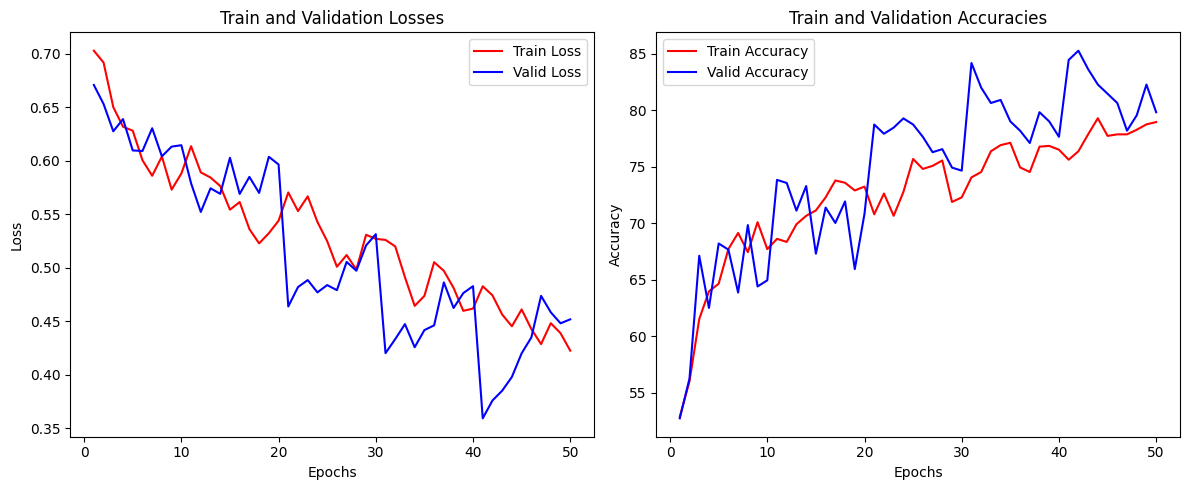

In [15]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Train Loss')
plt.plot(epochs, valid_losses, 'b', label='Valid Loss')
plt.title('Train and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r', label='Train Accuracy')
plt.plot(epochs, valid_accuracies, 'b', label='Valid Accuracy')
plt.title('Train and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluando el modelo

In [16]:
from sklearn.metrics import confusion_matrix

resnet18.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
#wandb.log({"Matriz_confusión": conf_matrix})


In [17]:
print(conf_matrix)

[[ 67  30]
 [  7 101]]


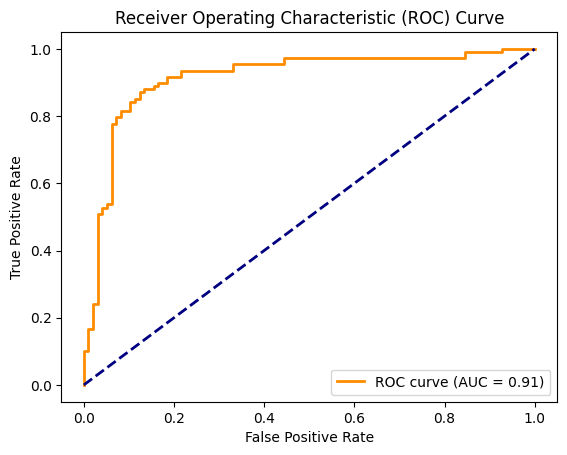

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

resnet18.eval()
with torch.no_grad():
    all_labels = []
    all_predictions = []
    for images, labels in test_loader:
        outputs = resnet18(images)
        predicted_probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted_probs.numpy())

all_predictions = np.array(all_predictions) 
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#wandb.log({"ROC Curve": wandb.Image(plt)})

plt.close()

In [19]:
#calcular el accuracy del test
resnet18.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet18(images)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 81.95%


In [20]:
wandb.finish()

Train Acc,▁▂▃▄▅▅▅▆▅▅▆▆▆▇▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇██████
Train Loss,██▇▆▅▅▆▅▆▅▅▅▄▄▄▄▅▄▅▄▃▃▃▄▄▃▃▂▃▃▂▂▃▂▂▂▂▁▂▁
Valid Acc,▁▂▄▃▄▃▅▄▆▅▅▅▅▅▅▄▇▆▇▇▆▆▆▆█▇▇▇▆▆▇▇███▇▇▆▇▇
Valid Loss,██▇▇▇▇▇▇▆▅▆▆▆▆▆▆▃▄▄▄▄▄▄▅▂▃▃▂▃▄▃▄▁▁▂▂▃▄▃▃
Train Acc,78.96528
Train Loss,0.4224
Valid Acc,79.83651
Valid Loss,0.4517


In [21]:
# Define a file path where you want to save the trained model
model_save_path = 'resnet18_Adamw81.pth'

# guardar ek modelo entrenado
torch.save(resnet18, model_save_path)

In [39]:
model_save_path = 'resnet18_Adamw81_95.pth'

# Carga todo el modelo completo
loaded_model = torch.load(model_save_path)

# Asegúrate de establecer el modelo en modo de evaluación

loaded_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
#calcular el accuracy del test
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = loaded_model(images)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 62.07%
